In [1]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCDIndependent'
pict_results_path = os.environ['PACKAGE_OUTPUT']+'/PCDIndependent/picts'
files_results_path = os.environ['PACKAGE_OUTPUT']+'/PCDIndependent/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 4.10079956055e-05 seconds
Time to read data file: 1.79621696472 seconds


In [2]:
# Get data in correct format
from keras.utils import np_utils

# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)

all_data = all_data.transpose()

# turn targets in sparse mode
trgt_sparse = np_utils.to_categorical(all_trgt)

Using Theano backend.
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [39]:
# Train Process
from Functions import LogFunctions as log

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry(package_name="PreProcessing",analysis_name='PCDIndependent')

m_time = time.time()

# Create a train information file
n_folds = 2
n_inits = 1
n_pcds = 4
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['n_pcds'] = n_pcds
train_info['norm'] = norm

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+date+'_classifiers'
pcd_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcds'

from sklearn import cross_validation
from sklearn import preprocessing

CVO = cross_validation.StratifiedKFold(all_trgt, train_info['n_folds'])
CVO = list(CVO)
train_info['CVO'] = CVO

joblib.dump([train_info],train_info_name,compress=9)

# train classifiers
classifiers = {}
trn_desc = {}
pcds = {}

for ifold in range(train_info['n_folds']):
    train_id, test_id = train_info['CVO'][ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
       
    print 'Train Process for %i Fold of %i Folds'%(ifold+1,train_info['n_folds'] )
    classifiers[ifold] = {}
    trn_desc[ifold] = {}
    pcds[ifold] = {}
    
    for ipcd in range(train_info['n_pcds']):
        print 'Process PCD %i of %i'%(ipcd+1, train_info['n_pcds'])
        best_init = 0
        best_loss = 999
        if ipcd == 0:
            # first pcd: regular NN
            for i_init in range(train_info['n_inits']):
                print 'Init: %i of %i'%(i_init+1,train_info['n_inits'])
                model = Sequential()
                model.add(Dense(all_data.shape[1],
                                input_dim=all_data.shape[1], 
                                init='identity',trainable=False))
                model.add(Activation('linear'))
                model.add(Dense(1, input_dim=all_data.shape[1], init='uniform'))
                model.add(Activation('tanh'))
                model.add(Dense(50, init='uniform'))
                model.add(Activation('tanh'))
                model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
                model.add(Activation('tanh'))
                
                sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
                model.compile(loss='mean_squared_error', optimizer=sgd
                      ,metrics=['accuracy'])
                
                earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
                # Train model
                init_trn_desc = model.fit(norm_all_data[train_id], trgt_sparse[train_id], 
                                nb_epoch=50, 
                                batch_size=8,
                                callbacks=[earlyStopping], 
                                verbose=0,
                                validation_data=(all_data[test_id],trgt_sparse[test_id]),
                                shuffle=True)
                if np.min(init_trn_desc.history['val_loss']) < best_loss:
                    best_init = i_init
                    best_loss = np.min(init_trn_desc.history['val_loss'])
                    classifiers[ifold][ipcd] = model
                    trn_desc[ifold][ipcd] = init_trn_desc
                    pcds[ifold][ipcd] = model.layers[2].get_weights()[0]
        else:
            # from second to end: remove the projection in weight init
            for i_init in range(train_info['n_inits']):
                print 'Init: %i of %i'%(i_init+1,train_info['n_inits'])
                model = Sequential()
                model.add(Dense(all_data.shape[1],
                                input_dim=all_data.shape[1], 
                                init='identity',trainable=False))
                model.add(Activation('linear'))
                model.add(Dense(1, input_dim=all_data.shape[1], init='uniform'))
                model.add(Activation('tanh'))
                model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
                model.add(Activation('tanh'))
                
                w = model.layers[2].get_weights()[0]
                w_proj = np.zeros_like(w)
                for i_old_pcd in range(ipcd):
                    w_proj = w_proj + (np.matmul(np.matmul(
                                pcds[ifold][i_old_pcd],w.T),pcds[ifold][i_old_pcd])/
                                       np.matmul(pcds[ifold][i_old_pcd].T,
                                                 pcds[ifold][i_old_pcd]))
                w_remove_proj = w - w_proj
                weights = model.layers[2].get_weights()
                weights[0] = w_remove_proj
                model.layers[2].set_weights(weights)
                
                sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
                model.compile(loss='mean_squared_error', optimizer=sgd
                      ,metrics=['accuracy'])
                
                earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
                data_proj = np.zeros_like(norm_all_data)
                for i_old_pcd in range(ipcd):
                    data_proj = data_proj + (np.matmul(np.matmul(
                            norm_all_data,pcds[ifold][i_old_pcd]),pcds[ifold][i_old_pcd].T)/
                                            np.matmul(pcds[ifold][i_old_pcd].T,
                                                      pcds[ifold][i_old_pcd]))
                
                # Train model
                init_trn_desc = model.fit(data_proj[train_id], trgt_sparse[train_id], 
                                nb_epoch=50, 
                                batch_size=8,
                                callbacks=[earlyStopping], 
                                verbose=0,
                                validation_data=(data_proj[test_id],trgt_sparse[test_id]),
                                shuffle=True)
                if np.min(init_trn_desc.history['val_loss']) < best_loss:
                    best_init = i_init
                    best_loss = np.min(init_trn_desc.history['val_loss'])
                    classifiers[ifold][ipcd] = model
                    trn_desc[ifold][ipcd] = init_trn_desc
                    pcds[ifold][ipcd] = model.layers[2].get_weights()[0]
            
m_time = time.time()-m_time
print 'Time to train all process: %1.3f seconds'%(m_time)

pcd_file = open(pcd_file_name+'.pickle', "wb")
pickle.dump([pcds],pcd_file)
pcd_file.close()

#classifiers_file = open(classifiers_name+'.pickle', "wb")
#pickle.dump([classifiers,trn_desc],classifiers_file)
#classifiers_file.close()

Train Process for 1 Fold of 2 Folds
Process PCD 1 of 4
Init: 1 of 1
Process PCD 2 of 4
Init: 1 of 1
Process PCD 3 of 4
Init: 1 of 1
Process PCD 4 of 4
Init: 1 of 1
Train Process for 2 Fold of 2 Folds
Process PCD 1 of 4
Init: 1 of 1
Process PCD 2 of 4
Init: 1 of 1
Process PCD 3 of 4
Init: 1 of 1
Process PCD 4 of 4
Init: 1 of 1
Time to train all process: 469.625 seconds


In [40]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="PreProcessing")
print log_entries

{0: {'date': '2016_08_04_12_25_24', 'package': 'PCDDeflaction'}, 1: {'date': '2016_08_05_13_47_46', 'package': 'PCDDeflaction'}, 2: {'date': '2016_08_05_14_01_36', 'package': 'PCDDeflaction'}, 3: {'date': '2016_08_05_14_01_52', 'package': 'PCDDeflaction'}, 4: {'date': '2016_08_05_14_05_18', 'package': 'PCDDeflaction'}, 5: {'date': '2016_08_05_14_10_15', 'package': 'PCDDeflaction'}, 6: {'date': '2016_08_05_14_10_34', 'package': 'PCDDeflaction'}, 7: {'date': '2016_08_05_14_10_55', 'package': 'PCDDeflaction'}, 8: {'date': '2016_08_05_14_13_23', 'package': 'PCDDeflaction'}, 9: {'date': '2016_08_05_14_14_31', 'package': 'PCDDeflaction'}, 10: {'date': '2016_08_05_14_16_01', 'package': 'PCDDeflaction'}, 11: {'date': '2016_08_05_14_19_56', 'package': 'PCDDeflaction'}, 12: {'date': '2016_08_05_14_28_33', 'package': 'PCDDeflaction'}, 13: {'date': '2016_08_05_14_31_13', 'package': 'PCDDeflaction'}, 14: {'date': '2016_08_05_14_36_59', 'package': 'PCDDeflaction'}, 15: {'date': '2016_08_05_14_47_33'

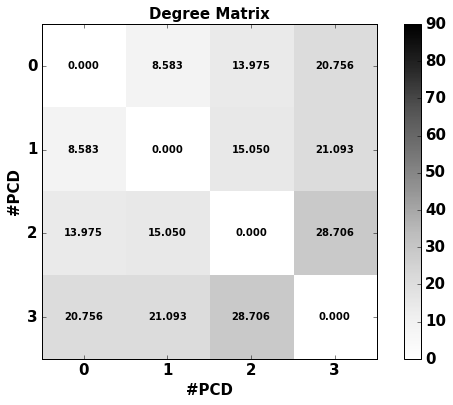

In [41]:
# Plot degree between each PCD
choose_date = '2016_08_09_12_26_23'
choose_fold = 0

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]
pcd_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcds'

degree_matrix = np.zeros([train_info['n_pcds'],train_info['n_pcds']])

pcd_file = open(pcd_file_name+'.pickle', "r")
pcds = pickle.load(pcd_file)
pcd_file.close()
pcds = pcds[0]


for ipcd in range(train_info['n_pcds']):
    for jpcd in range(train_info['n_pcds']):
        degree = (np.matmul(pcds[choose_fold][ipcd].T,pcds[choose_fold][jpcd])/
                 (np.linalg.norm(pcds[choose_fold][ipcd])*
                  np.linalg.norm(pcds[choose_fold][jpcd])))
        degree = round(degree.real,4)
        degree = np.arccos(degree)
        degree = np.degrees(degree)
        if degree > 90 and degree < 180:
            degree = degree - 180
        if degree > 180 and degree < 270:
            degree = degree - 180
        degree_matrix[ipcd,jpcd] = np.abs(degree)

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im =ax.imshow(degree_matrix, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 90.0))
width, height = degree_matrix.shape

for x in xrange(width):
    for y in xrange(height):
        if degree_matrix[x][y] < 45.:
            ax.annotate('%1.3f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Degree Matrix',fontweight='bold',fontsize=15)
ax.set_ylabel('#PCD',fontweight='bold',fontsize=15)
ax.set_xlabel('#PCD',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(train_info['n_pcds'])   
ax.xaxis.set_ticks(tick_marks)
ax.yaxis.set_ticks(tick_marks)

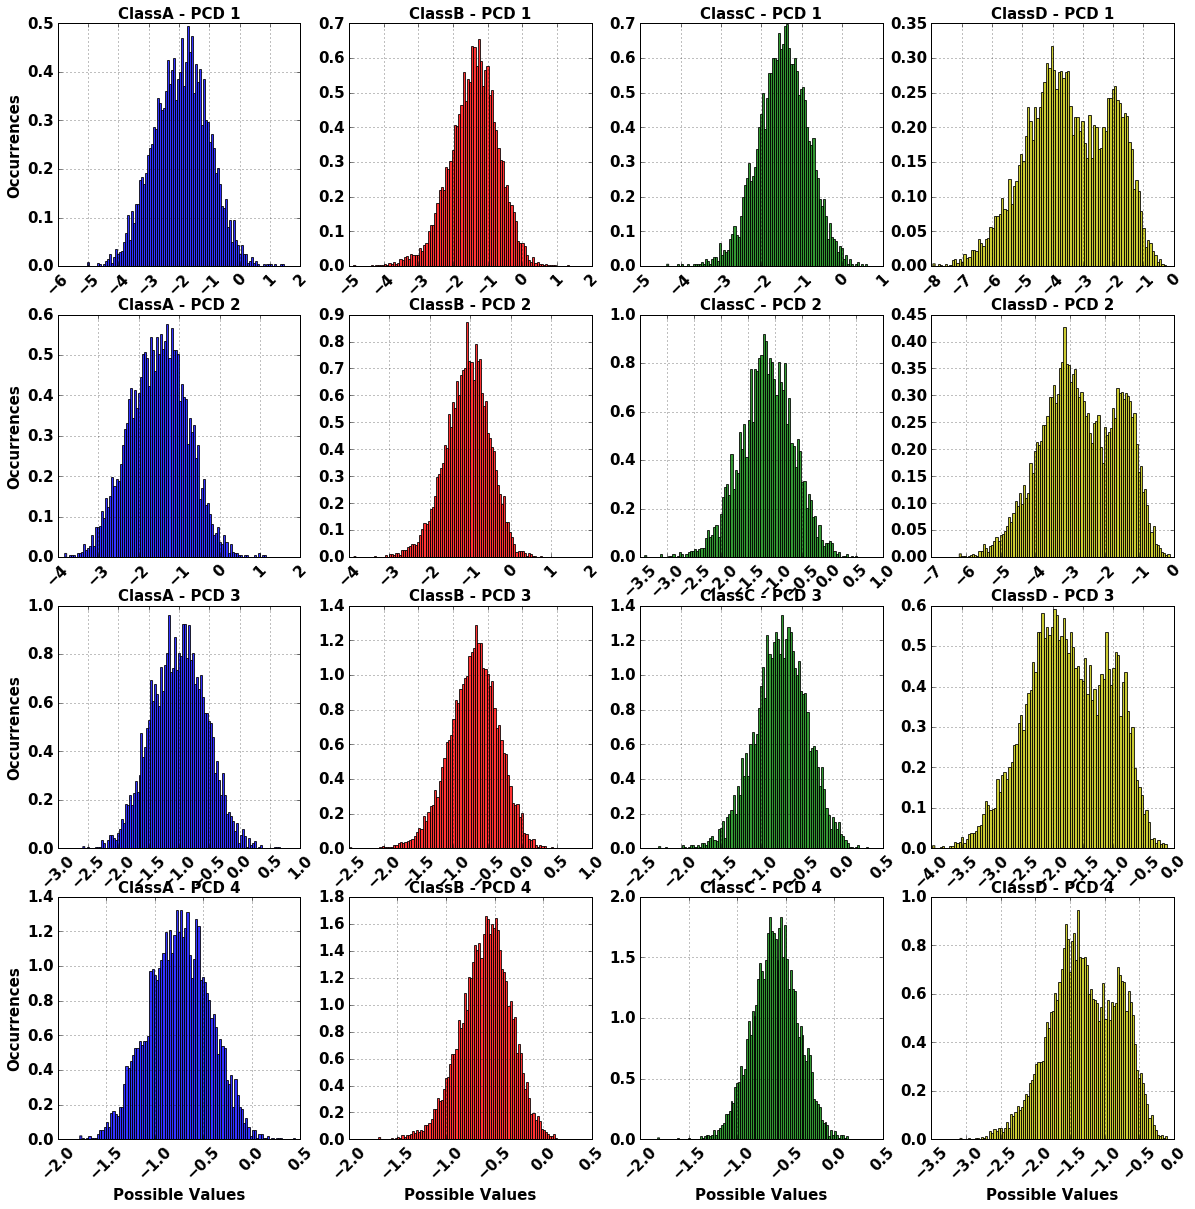

In [64]:
# Plot distributions of Proj Data in each PCD
choose_date = '2016_08_09_12_26_23'
choose_fold = 0

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]
pcd_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcds'

pcd_file = open(pcd_file_name+'.pickle', "r")
pcds = pickle.load(pcd_file)
pcd_file.close()
pcds = pcds[0]

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

n_classes = 4

fig, ax = plt.subplots(figsize=(20,20),nrows=train_info['n_pcds'], ncols=n_classes)
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']


for iclass in range(n_classes):
    for ipcd in range(train_info['n_pcds']):
        
        ax[ipcd,iclass].set_title('%s - PCD %i'%(class_labels[iclass],ipcd+1),
                                  fontweight='bold',fontsize=15)
        
        if ipcd == train_info['n_pcds']-1:
            ax[ipcd,iclass].set_xlabel('Possible Values',
                                         fontweight='bold',fontsize=15)
        if iclass == 0:
            ax[ipcd,iclass].set_ylabel('Occurrences',
                                             fontweight='bold',fontsize=15)
            
        plot_data = all_data[all_trgt==iclass]
        proj_data = np.matmul(plot_data,pcds[choose_fold][ipcd])
        n_bins = np.linspace(proj_data.min(),proj_data.max(),100)
        n, bins, patches = ax[ipcd,iclass].hist(proj_data,bins=n_bins,
                                                      fc=m_colors[iclass],
                                                      alpha=0.8, normed=1)
        
        for tick in ax[ipcd,iclass].get_xticklabels():
            tick.set_rotation(45)
        ax[ipcd,iclass].grid()

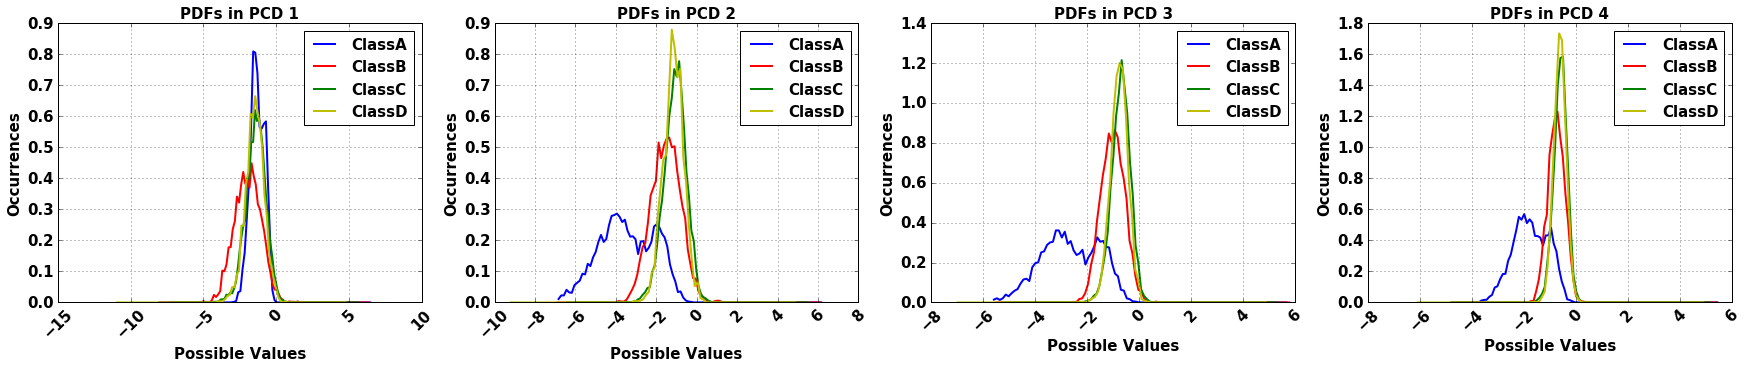

In [65]:
# Plot PDFs of Proj Data in each PCD

from sklearn.neighbors import KernelDensity

choose_date = '2016_08_09_12_26_23'
choose_fold = 0

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]
pcd_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcds'

pcd_file = open(pcd_file_name+'.pickle', "r")
pcds = pickle.load(pcd_file)
pcd_file.close()
pcds = pcds[0]

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

n_rows = 1

fig, ax = plt.subplots(figsize=(30,5),nrows=n_rows, 
                       ncols=int(np.ceil(train_info['n_pcds']/n_rows)))
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']


kernel = 'epanechnikov' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'

for ipcd in range(train_info['n_pcds']):
    for iclass in range(len(class_labels)):
                
        ax[ipcd].set_title('PDFs in PCD %i'%(ipcd+1),fontweight='bold',fontsize=15)
        ax[ipcd].set_xlabel('Possible Values',fontweight='bold',fontsize=15)
        ax[ipcd].set_ylabel('Occurrences',fontweight='bold',fontsize=15)
        
        plot_data = all_data[all_trgt==iclass]
        proj_data = np.matmul(plot_data,pcds[choose_fold][ipcd])
        n_bins = np.linspace(proj_data.min()-3.0,proj_data.max()+5.0,100)
        
        log_dens_x = kde.score_samples(n_bins[:, np.newaxis])
        kde = KernelDensity(kernel=kernel,algorithm='auto',
                            bandwidth=0.05).fit(proj_data)
        ax[ipcd].plot(n_bins, np.exp(log_dens_x),
                      color=m_colors[iclass],
                      linewidth=2.0,label=class_labels[iclass])
    handles, labels = ax[ipcd].get_legend_handles_labels()
    ax[ipcd].legend(handles, labels,loc='best')
        
    for tick in ax[ipcd].get_xticklabels():
        tick.set_rotation(45)
    ax[ipcd].grid()

In [14]:
np.ceil(train_info['n_pcds']/n_rows)

3.0